
Exploring /content/Comys_Hackathon5/Task_B/train:
Total people: 877


100%|██████████| 10/10 [00:00<00:00, 1151.59it/s]



Sample stats (first 10 people):
Avg images per person: 11.2
Max images: 40 | Min images: 8

Example folder structure for '095_frontal':
095_frontal/
    095_frontal.jpg
    distortion/
        095_frontal_blurred.jpg
        095_frontal_foggy.jpg...
    distortion/

Extracting face embeddings...


Processing /content/Comys_Hackathon5/Task_B/train: 100%|██████████| 877/877 [26:33<00:00,  1.82s/it]
Processing /content/Comys_Hackathon5/Task_B/val: 100%|██████████| 250/250 [06:12<00:00,  1.49s/it]



Generating verification pairs...

Verification Performance:
Accuracy: 0.8829
Optimal threshold: 0.2834
AUC: 0.9515


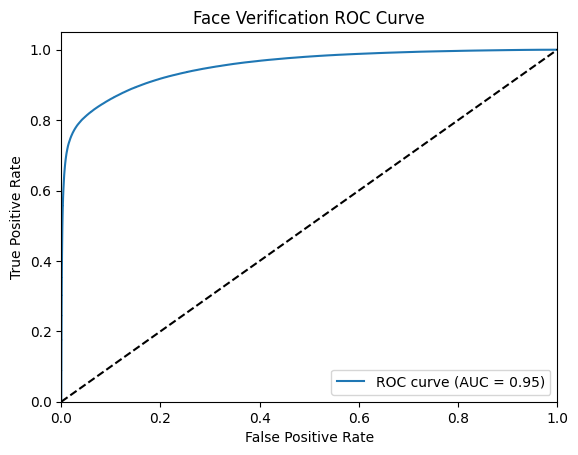


Testing sample pairs:

Image 1: Bulent_Ecevit_0002_rainy.jpg
Image 2: Bulent_Ecevit_0006_foggy.jpg
Similarity: 0.5168 | Predicted: Match
Actual: Match

Image 1: Colin_Powell_0160.jpg
Image 2: Colin_Powell_0047_blurred.jpg
Similarity: 0.2170 | Predicted: Non-match
Actual: Match

Image 1: 107_frontal_foggy.jpg
Image 2: 107_frontal_blurred.jpg
Similarity: 0.9387 | Predicted: Match
Actual: Match


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Setup device and models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=False, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# 2. Dataset exploration
def explore_dataset(folder):
    print(f"\nExploring {folder}:")
    persons = os.listdir(folder)
    print(f"Total people: {len(persons)}")

    # Count images per person
    img_counts = []
    for person in tqdm(persons[:10]):  # Sample first 10 for demo
        person_dir = os.path.join(folder, person)
        images = []
        for root, _, files in os.walk(person_dir):
            images.extend([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        img_counts.append(len(images))

    print(f"\nSample stats (first 10 people):")
    print(f"Avg images per person: {np.mean(img_counts):.1f}")
    print(f"Max images: {max(img_counts)} | Min images: {min(img_counts)}")

    # Show folder structure example
    sample_person = persons[0]
    print(f"\nExample folder structure for '{sample_person}':")
    sample_path = os.path.join(folder, sample_person)
    for root, dirs, files in os.walk(sample_path):
        level = root.replace(sample_path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        if level == 0:
            for f in files[:2]:
                print(f"{indent}    {f}")
        if 'distortion' in dirs:
            dist_path = os.path.join(root, 'distortion')
            dist_files = os.listdir(dist_path)[:2]
            print(f"{indent}    distortion/")
            print(f"{indent}        {dist_files[0]}")
            print(f"{indent}        {dist_files[1]}...")

# 3. Face embedding extraction
def get_embedding(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        face = mtcnn(img)
        if face is None:
            return None
        with torch.no_grad():
            emb = facenet(face.unsqueeze(0).to(device))
        return emb.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

# 4. Load dataset with embeddings
def load_embeddings(folder):
    embeddings = []
    labels = []
    img_paths = []

    persons = os.listdir(folder)
    for person in tqdm(persons, desc=f"Processing {folder}"):
        person_dir = os.path.join(folder, person)

        # Process all images including distortions
        for root, _, files in os.walk(person_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)
                    emb = get_embedding(img_path)
                    if emb is not None:
                        embeddings.append(emb)
                        labels.append(person)
                        img_paths.append(img_path)

    return np.array(embeddings), np.array(labels), img_paths

# 5. Generate verification pairs
def generate_pairs(embeddings, labels):
    positives = []
    negatives = []

    unique_labels = np.unique(labels)
    label_to_indices = {label: np.where(labels == label)[0] for label in unique_labels}

    # Positive pairs (same person)
    for label, indices in label_to_indices.items():
        if len(indices) >= 2:
            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    positives.append((indices[i], indices[j]))

    # Negative pairs (different people)
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            idx1 = np.random.choice(label_to_indices[unique_labels[i]])
            idx2 = np.random.choice(label_to_indices[unique_labels[j]])
            negatives.append((idx1, idx2))

    return positives, negatives

# 6. Main execution
if __name__ == "__main__":
    # Dataset paths (modify as needed)
    train_dir = "/content/Comys_Hackathon5/Task_B/train"
    val_dir = "/content/Comys_Hackathon5/Task_B/val"

    # Explore dataset structure
    explore_dataset(train_dir)

    # Load embeddings
    print("\nExtracting face embeddings...")
    X_train, y_train, train_paths = load_embeddings(train_dir)
    X_val, y_val, val_paths = load_embeddings(val_dir)

    # Combine train and val for verification
    X_all = np.vstack([X_train, X_val])
    y_all = np.concatenate([y_train, y_val])
    paths_all = train_paths + val_paths

    # Generate pairs
    print("\nGenerating verification pairs...")
    pos_pairs, neg_pairs = generate_pairs(X_all, y_all)

    # Balance and prepare dataset
    n_pairs = min(len(pos_pairs), len(neg_pairs))
    pairs = pos_pairs[:n_pairs] + neg_pairs[:n_pairs]
    pair_labels = [1]*n_pairs + [0]*n_pairs

    # Compute similarities
    def cosine_sim(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    X_sim = np.array([cosine_sim(X_all[i], X_all[j]) for i,j in pairs])

    # Train/test split
    X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(
        X_sim, pair_labels, test_size=0.2, random_state=42)

    # Find optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train_sim, X_train_sim)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Evaluate
    y_pred = (X_test_sim >= optimal_threshold).astype(int)

    print("\nVerification Performance:")
    print(f"Accuracy: {accuracy_score(y_test_sim, y_pred):.4f}")
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"AUC: {auc(fpr, tpr):.4f}")

    # ROC Curve visualization
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Face Verification ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Example pair testing
    print("\nTesting sample pairs:")
    for _ in range(3):
        idx = np.random.choice(len(pairs))
        i, j = pairs[idx]
        sim = X_sim[idx]
        print(f"\nImage 1: {paths_all[i].split('/')[-1]}")
        print(f"Image 2: {paths_all[j].split('/')[-1]}")
        print(f"Similarity: {sim:.4f} | Predicted: {'Match' if sim >= optimal_threshold else 'Non-match'}")
        print(f"Actual: {'Match' if pair_labels[idx] == 1 else 'Non-match'}")